# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.592012,True,3.894581
1,-1.479960,False,-2.863655
2,-0.251235,True,2.245327
3,-1.041088,False,-0.999206
4,-1.750545,False,-2.747202
...,...,...,...
995,-1.787089,False,-2.068983
996,0.161276,False,1.757213
997,-0.697401,True,3.112675
998,-1.573482,False,-1.577905


<Axes: xlabel='v0'>

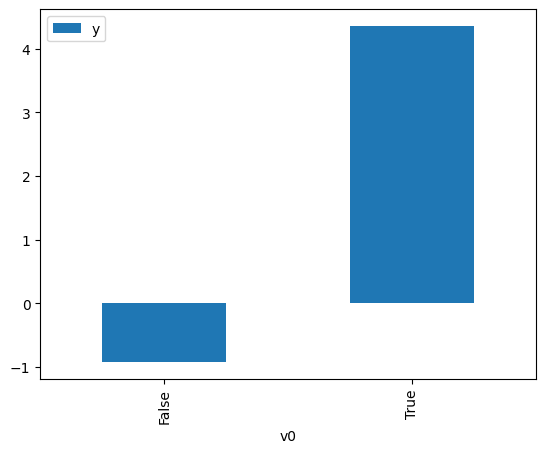

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

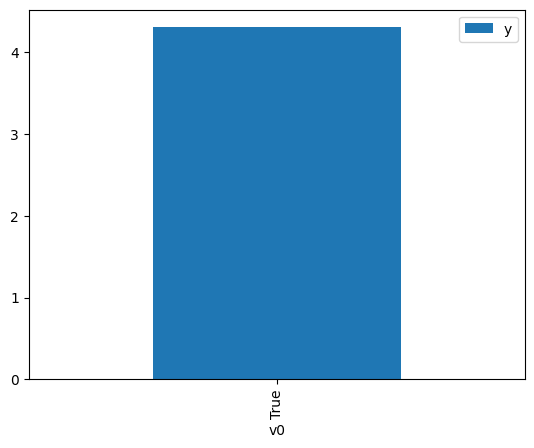

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.455173,False,-1.248640,0.716610,1.395460
1,-0.637371,False,-0.585777,0.772349,1.294751
2,-0.316185,False,0.248028,0.668963,1.494852
3,-1.451661,False,-3.019569,0.926574,1.079245
4,-3.205686,False,-2.904923,0.995343,1.004679
...,...,...,...,...,...
995,1.034696,False,1.682300,0.186077,5.374109
996,-0.804878,False,-1.357767,0.816354,1.224958
997,-0.220636,False,-0.344087,0.633987,1.577319
998,-1.398871,False,-0.893248,0.920565,1.086289


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.433009,True,3.411193,0.075500,13.245054
1,-0.804649,True,5.358388,0.183701,5.443631
2,-0.817897,True,3.842068,0.180518,5.539617
3,-2.418384,True,2.988295,0.016388,61.021287
4,-0.997177,True,4.811284,0.141601,7.062074
...,...,...,...,...,...
995,-1.914544,True,3.291791,0.036197,27.626861
996,-0.804649,True,5.358388,0.183701,5.443631
997,-0.726244,True,4.635449,0.203430,4.915690
998,-0.132695,True,4.812335,0.399513,2.503049


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              4858.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:20:53   Log-Likelihood:                         -1388.1
No. Observations:                1000   AIC:                                      2780.
Df Residuals:                     998   BIC:                                      2790.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0887      0.024     46.236      0.000       1.042       1.135
x2             5.0614      0.059     85.652      0.000       4.945       5.177
==============================================================================
Omnibus:                        0.313   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.855   Jarque-Bera (JB):                0.401
Skew:                           0.015   Prob(JB):                        0.818
Kurtosis:                       2.906   Cond. No.                         2.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""